In [4]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# %cd /content/drive/MyDrive/Colab Notebooks/Disertasi-Ahmad-Rofiqul/002.Experiment_SWI_16052024/

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.svm import OneClassSVM

In [6]:
# Load the dataset
# file_path = '01.Dataset-Rofiqul/012_N2O_Soft_Voting_agriculture_dataset.csv'
file_path = '01.Dataset-Rofiqul/BeforeRemoveOutliers/019_data_with_COMBINATION_hard_soft_voting_outliers.csv' #dataset baru

data = pd.read_csv(file_path)

# Display the first few rows of the dataset for review
# data.head(), data.info()

##  Hard & Soft Voting

In [7]:
print('Hard Voting')
print("Data Outlier: "+str((data['Hard_Voting_Outlier'] != 1).sum()))
print("Data Inlier: "+str((data['Hard_Voting_Outlier'] == 1).sum()))
print('Soft Voting')
print("Data Outlier: "+str((data['Soft_Voting_Outlier'] != 1).sum()))
print("Data Inlier: "+str((data['Soft_Voting_Outlier'] == 1).sum()))

Hard Voting
Data Outlier: 165
Data Inlier: 2081
Soft Voting
Data Outlier: 734
Data Inlier: 1512


In [8]:
#redeclare data variabel now only contain inlier
data=data[data['Soft_Voting_Outlier'] == 1]
data.head(),data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1512 entries, 0 to 2244
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 1512 non-null   int64  
 1   Year                 1512 non-null   float64
 2   Experiment           1512 non-null   int64  
 3   DataUse              1512 non-null   int64  
 4   Replication          1512 non-null   int64  
 5   Month                1512 non-null   int64  
 6   Vegetation           1512 non-null   int64  
 7   VegType              1512 non-null   int64  
 8   N2O                  1512 non-null   float64
 9   N_rate               1512 non-null   float64
 10  PP2                  1512 non-null   float64
 11  PP7                  1512 non-null   float64
 12  AirT                 1512 non-null   float64
 13  DAF_TD               1512 non-null   float64
 14  DAF_SD               1512 non-null   float64
 15  WFPS25cm             1512 non-null   float6

(   Date      Year  Experiment  DataUse  Replication  Month  Vegetation  \
 0   424  0.020682           1        0            0      3           0   
 1   360  0.020682           1        0            0      3           0   
 2   379  0.020682           1        0            0      3           0   
 3   382  0.020682           1        0            0      3           0   
 4   455  0.020682           1        0            0      7           0   
 
    VegType       N2O    N_rate  ...       NO3      Clay      Sand       SOM  \
 0        0 -0.125408  0.481233  ... -0.083017 -0.904182  0.796768 -0.642242   
 1        0 -0.185324  0.481233  ... -0.082259 -0.904182  0.796768 -0.642242   
 2        0 -0.137842  0.481233  ... -0.071667 -0.904182  0.796768 -0.642242   
 3        0 -0.144855  0.481233  ... -0.069647 -0.904182  0.796768 -0.642242   
 4        0 -0.158726  0.481233  ... -0.031903 -0.904182  0.796768 -0.642242   
 
    IF_Outlier  DBSCAN_Outlier  OCSVM_Outlier  Hard_Voting_Outlier

## Prepare Train Test Split

In [9]:
from sklearn.model_selection import train_test_split,GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns


In [10]:
# Encode categorical variables if any
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

# Split the data into features and target variable
X = data.drop(columns=['N2O'])
y = data['N2O']


## Define GridSearchCV and RandomizedCV

In [15]:
def grid_search_cv(X_train, y_train):
    param_grid = {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'n_estimators': [100, 200, 300],
        'colsample_bytree': [0.3, 0.7]
    }
    model = xgb.XGBRegressor(objective='reg:squarederror', seed=42)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, grid_search.best_params_, -grid_search.best_score_


In [16]:

def randomized_search_cv(X_train, y_train):
    param_dist = {
        'max_depth': [3, 4, 5, 6, 7, 8],
        'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
        'n_estimators': [100, 200, 300, 400, 500],
        'colsample_bytree': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    }
    model = xgb.XGBRegressor(objective='reg:squarederror', seed=42)
    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=100, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2, random_state=42)
    random_search.fit(X_train, y_train)
    return random_search.best_estimator_, random_search.best_params_, -random_search.best_score_


## K-Fold XGBoost

In [44]:
def kfold_xgboost_cv(X_train, y_train):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    params = {
        "objective": "reg:squarederror",
        'colsample_bytree': 0.3,
        'learning_rate': 0.1,
        'max_depth': 5,
        'alpha': 10,
        'seed': 42
    }
    cv_results = xgb.cv(dtrain=dtrain, params=params, nfold=3, num_boost_round=50, early_stopping_rounds=10, metrics="rmse", as_pandas=True, seed=42)
    best_num_boost_rounds = cv_results.shape[0]
    best_score = cv_results['test-rmse-mean'].min()
    return best_num_boost_rounds, best_score


## Standard CrossValidation

In [45]:
def standard_crossval(X_train, y_train):
    model = xgb.XGBRegressor(objective='reg:squarederror', seed=42)
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
    return -scores.mean()

## Split Train Test With Different Test Size

In [20]:
test_sizes = [0.2, 0.25, 0.3, 0.35]
results = []

for test_size in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # GridSearchCV
    best_model_gs, best_params_gs, best_score_gs = grid_search_cv(X_train, y_train)
    y_pred_gs = best_model_gs.predict(X_test)
    mse_gs = mean_squared_error(y_test, y_pred_gs)
    rmse_gs = np.sqrt(mse_gs)
    mae_gs = mean_absolute_error(y_test, y_pred_gs)
    r2_gs = r2_score(y_test, y_pred_gs)

    results.append({
        'test_size': test_size,
        'method': 'GridSearchCV',
        'best_params': best_params_gs,
        'cv_score': best_score_gs,
        'mse': mse_gs,
        'rmse': rmse_gs,
        'mae': mae_gs,
        'r2': r2_gs
    })




Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=300; total time=   0.2s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=300; total time=   0.2s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=300; total time=   0.2s
[CV] END colsample_bytree=0.3

In [21]:
results

[{'test_size': 0.2,
  'method': 'GridSearchCV',
  'best_params': {'colsample_bytree': 0.3,
   'learning_rate': 0.1,
   'max_depth': 7,
   'n_estimators': 200},
  'cv_score': 0.02225813050675417,
  'mse': 0.014967326930662073,
  'rmse': 0.12234102717674915,
  'mae': 0.07504886418802774,
  'r2': 0.6620592480433175},
 {'test_size': 0.25,
  'method': 'GridSearchCV',
  'best_params': {'colsample_bytree': 0.3,
   'learning_rate': 0.1,
   'max_depth': 7,
   'n_estimators': 100},
  'cv_score': 0.022975524909543618,
  'mse': 0.01567218967936603,
  'rmse': 0.1251886164128593,
  'mae': 0.08071236864091076,
  'r2': 0.6293134864873609},
 {'test_size': 0.3,
  'method': 'GridSearchCV',
  'best_params': {'colsample_bytree': 0.3,
   'learning_rate': 0.1,
   'max_depth': 7,
   'n_estimators': 100},
  'cv_score': 0.023777514134323205,
  'mse': 0.015104817114209853,
  'rmse': 0.12290165627122301,
  'mae': 0.07911451553559468,
  'r2': 0.6268447265288295},
 {'test_size': 0.35,
  'method': 'GridSearchCV',
  

In [24]:
for test_size in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # RandomizedSearchCV
    best_model_rs, best_params_rs, best_score_rs = randomized_search_cv(X_train, y_train)
    y_pred_rs = best_model_rs.predict(X_test)
    mse_rs = mean_squared_error(y_test, y_pred_rs)
    rmse_rs = np.sqrt(mse_rs)
    mae_rs = mean_absolute_error(y_test, y_pred_rs)
    r2_rs = r2_score(y_test, y_pred_rs)

    results.append({
        'test_size': test_size,
        'method': 'RandomizedSearchCV',
        'best_params': best_params_rs,
        'cv_score': best_score_rs,
        'mse': mse_rs,
        'rmse': rmse_rs,
        'mae': mae_rs,
        'r2': r2_rs
    })


Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, n_estimators=400; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, n_estimators=400; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=8, n_estimators=100; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, n_estimators=400; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=8, n_estimators=100; total time=   0.3s
[CV] END colsample_bytree=0.3, learning_rate=0.2, max_depth=5, n_estimators=200; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=8, n_estimators=100; total time=   0.3s
[CV] END colsample_bytree=0.3, learning_rate=0.2, max_depth=5, n_estimators=200; total time=   0.2s
[CV] END colsample_bytree=0.3, learning_rate=0.2, max_depth=5, n_estimators=200; total time=   0.2s
[CV] END colsample_bytree=0.5, learni

In [46]:
for test_size in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    # K-Fold CrossValidation with XGBoost
    # dtrain = xgb.DMatrix(X_train, label=y_train)
    params = {
        "objective": "reg:squarederror",
        'colsample_bytree': 0.3,
        'learning_rate': 0.1,
        'max_depth': 5,
        'alpha': 10,
        'seed': 42
    }
    best_num_boost_rounds_kf, best_score_kf = kfold_xgboost_cv(X_train, y_train)
    model_kf = xgb.train(params, xgb.DMatrix(X_train, label=y_train), num_boost_round=best_num_boost_rounds_kf)
    y_pred_kf = model_kf.predict(xgb.DMatrix(X_test))
    mse_kf = mean_squared_error(y_test, y_pred_kf)
    rmse_kf = np.sqrt(mse_kf)
    mae_kf = mean_absolute_error(y_test, y_pred_kf)
    r2_kf = r2_score(y_test, y_pred_kf)

    # Standard CrossValidation
    best_score_sc = standard_crossval(X_train, y_train)
    model_sc = xgb.XGBRegressor(objective='reg:squarederror', seed=42).fit(X_train, y_train)
    y_pred_sc = model_sc.predict(X_test)
    mse_sc = mean_squared_error(y_test, y_pred_sc)
    rmse_sc = np.sqrt(mse_sc)
    mae_sc = mean_absolute_error(y_test, y_pred_sc)
    r2_sc = r2_score(y_test, y_pred_sc)

    
    results.append({
        'test_size': test_size,
        'method': 'KFoldXGBoost',
        'best_params': None,
        'cv_score': best_score_kf,
        'mse': mse_kf,
        'rmse': rmse_kf,
        'mae': mae_kf,
        'r2': r2_kf
    })
    results.append({
        'test_size': test_size,
        'method': 'StandardCrossVal',
        'best_params': None,
        'cv_score': best_score_sc,
        'mse': mse_sc,
        'rmse': rmse_sc,
        'mae': mae_sc,
        'r2': r2_sc
    })

In [75]:
results_df = pd.DataFrame(results)
results_df


,test_size,method,best_params,cv_score,mse,rmse,mae,r2
0,0.20,GridSearchCV,"{'colsample_bytree': 0.3, 'learning_rate': 0.1...",0.022258,0.014967,0.122341,0.075049,0.662059
1,0.25,GridSearchCV,"{'colsample_bytree': 0.3, 'learning_rate': 0.1...",0.022976,0.015672,0.125189,0.080712,0.629313
2,0.30,GridSearchCV,"{'colsample_bytree': 0.3, 'learning_rate': 0.1...",0.023778,0.015105,0.122902,0.079115,0.626845
3,0.35,GridSearchCV,"{'colsample_bytree': 0.3, 'learning_rate': 0.1...",0.026507,0.013815,0.117538,0.075509,0.625623
4,0.20,RandomizedSearchCV,"{'n_estimators': 200, 'max_depth': 8, 'learnin...",0.021521,0.014395,0.119981,0.072253,0.674974
5,0.25,RandomizedSearchCV,"{'n_estimators': 200, 'max_depth': 8, 'learnin...",0.022165,0.015233,0.123422,0.078882,0.639703
6,0.30,RandomizedSearchCV,"{'n_estimators': 400, 'max_depth': 8, 'learnin...",0.022818,0.014980,0.122394,0.077530,0.629923
7,0.35,RandomizedSearchCV,"{'n_estimators': 200, 'max_depth': 8, 'learnin...",0.025494,0.013761,0.117306,0.075605,0.627097
8,0.20,KFoldXGBoost,None,0.189216,0.036107,0.190019,0.113451,0.184750
9,0.20,StandardCrossVal,None,0.025925,0.014278,0.119492,0.073849,0.677618


In [76]:

# Save the results to a CSV file
# results_df.to_csv('01.Dataset-Rofiqul/AfterRemoveOutliers/019_1_xgboost_cross_validated_hyperparameter_tuning_results_nooutliers.csv', index=False)
results_df.to_csv('01.Dataset-Rofiqul/AfterRemoveOutliers/019_1_xgboost_cross_validated_KFoldXGBvsStandardCrossVal_results_nooutliers.csv', index=False)

# Display the results DataFrame
print(results_df)


    test_size              method  \
0        0.20        GridSearchCV   
1        0.25        GridSearchCV   
2        0.30        GridSearchCV   
3        0.35        GridSearchCV   
4        0.20  RandomizedSearchCV   
5        0.25  RandomizedSearchCV   
6        0.30  RandomizedSearchCV   
7        0.35  RandomizedSearchCV   
8        0.20        KFoldXGBoost   
9        0.20    StandardCrossVal   
10       0.25        KFoldXGBoost   
11       0.25    StandardCrossVal   
12       0.30        KFoldXGBoost   
13       0.30    StandardCrossVal   
14       0.35        KFoldXGBoost   
15       0.35    StandardCrossVal   

                                          best_params  cv_score       mse  \
0   {'colsample_bytree': 0.3, 'learning_rate': 0.1...  0.022258  0.014967   
1   {'colsample_bytree': 0.3, 'learning_rate': 0.1...  0.022976  0.015672   
2   {'colsample_bytree': 0.3, 'learning_rate': 0.1...  0.023778  0.015105   
3   {'colsample_bytree': 0.3, 'learning_rate': 0.1...  0.02650

In [88]:
# Extract the best parameters for each test_size
best_params_df = results_df[['test_size', 'method', 'best_params']].dropna()

# Convert the 'best_params' from string to dictionary
# best_params_df['best_params'] = best_params_df['best_params'].apply(eval)

# Normalize the 'best_params' dictionary into separate columns
best_params_expanded_df = pd.json_normalize(best_params_df['best_params'])
best_params_final_df = pd.concat([best_params_df[['test_size', 'method']], best_params_expanded_df], axis=1)

# Save the best parameters to a CSV file
# best_params_final_df.to_csv('path_to_save/best_params.csv', index=False)
results_df.to_csv('01.Dataset-Rofiqul/AfterRemoveOutliers/020_1_xgboost_BestParameters_GridSearchCV_RandomizedCV_results_nooutliers.csv', index=False)

best_params_final_df

,test_size,method,colsample_bytree,learning_rate,max_depth,n_estimators
0,0.20,GridSearchCV,0.3,0.10,7,200
1,0.25,GridSearchCV,0.3,0.10,7,100
2,0.30,GridSearchCV,0.3,0.10,7,100
3,0.35,GridSearchCV,0.3,0.10,7,100
4,0.20,RandomizedSearchCV,0.3,0.05,8,200
5,0.25,RandomizedSearchCV,0.3,0.05,8,200
6,0.30,RandomizedSearchCV,0.3,0.05,8,400
7,0.35,RandomizedSearchCV,0.3,0.05,8,200


## Cross Validation Comparison 

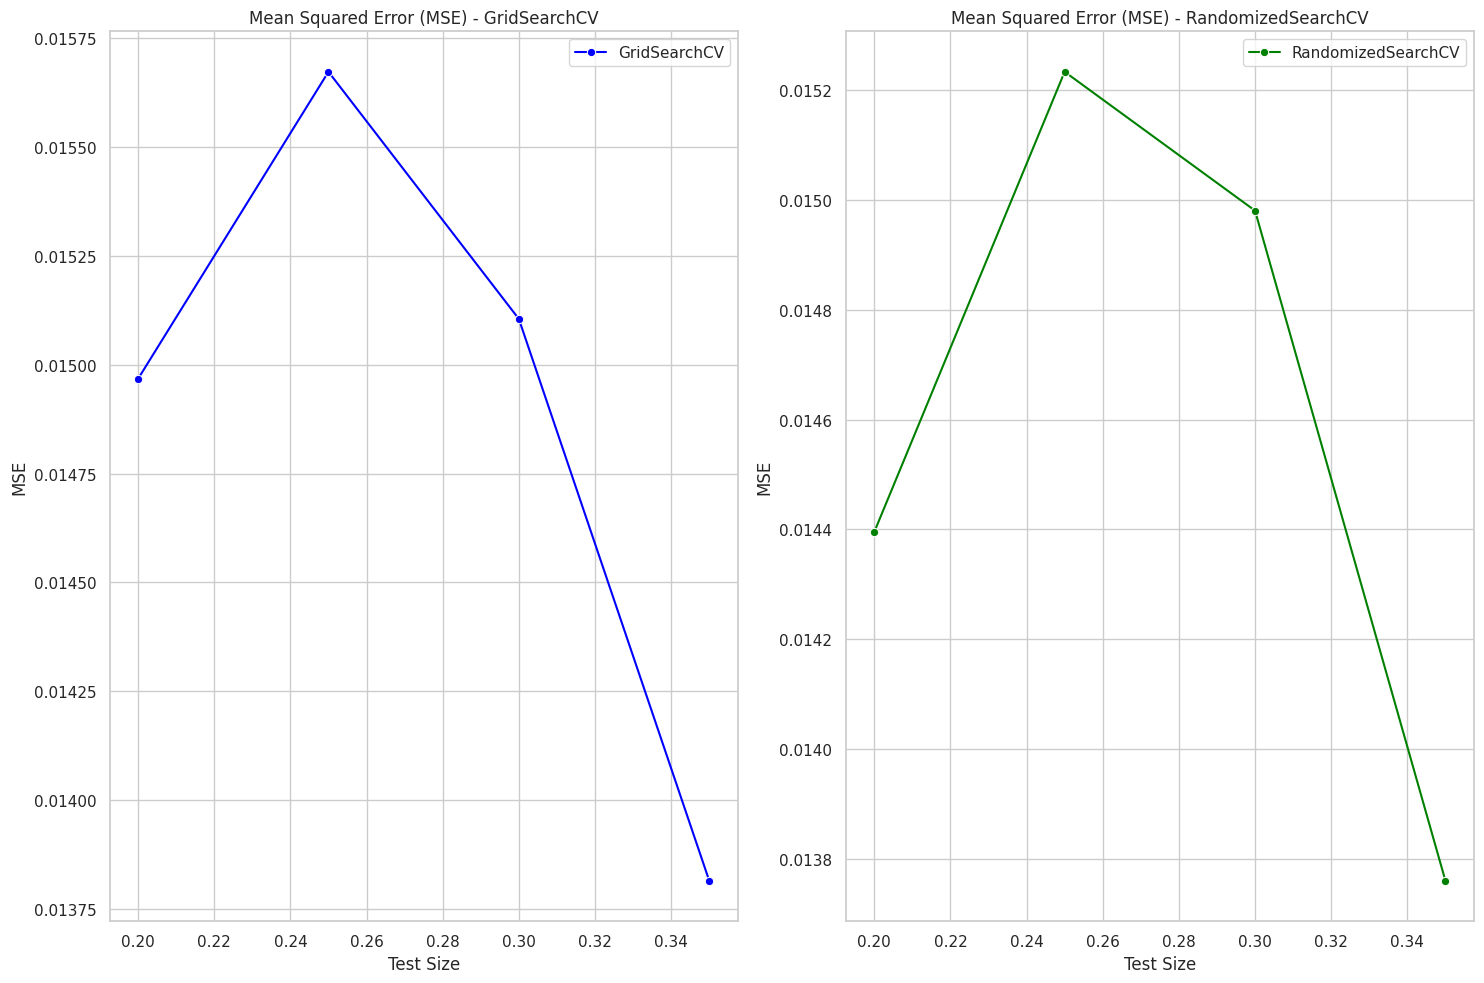

In [50]:
# Filter results for each cross-validation method
grid_search_df = results_df[results_df['method'] == 'GridSearchCV']
random_search_df = results_df[results_df['method'] == 'RandomizedSearchCV']

# Set the style of the visualization
sns.set(style="whitegrid")

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 10))

# Plot MSE for GridSearchCV
sns.lineplot(x='test_size', y='mse', data=grid_search_df, marker='o', ax=axs[0], label='GridSearchCV',color='blue')
axs[0].set_title('Mean Squared Error (MSE) - GridSearchCV')
axs[0].set_xlabel('Test Size')
axs[0].set_ylabel('MSE')

# Plot MSE for RandomizedSearchCV
sns.lineplot(x='test_size', y='mse', data=random_search_df, marker='o', ax=axs[1], label='RandomizedSearchCV',color='green')
axs[1].set_title('Mean Squared Error (MSE) - RandomizedSearchCV')
axs[1].set_xlabel('Test Size')
axs[1].set_ylabel('MSE')

plt.tight_layout()
plt.savefig('01.Dataset-Rofiqul/Visual/AfterRemoveOutliers/004_0_EvaluationResult_HyperparameterTuning_NoOutlier.png')

plt.show()

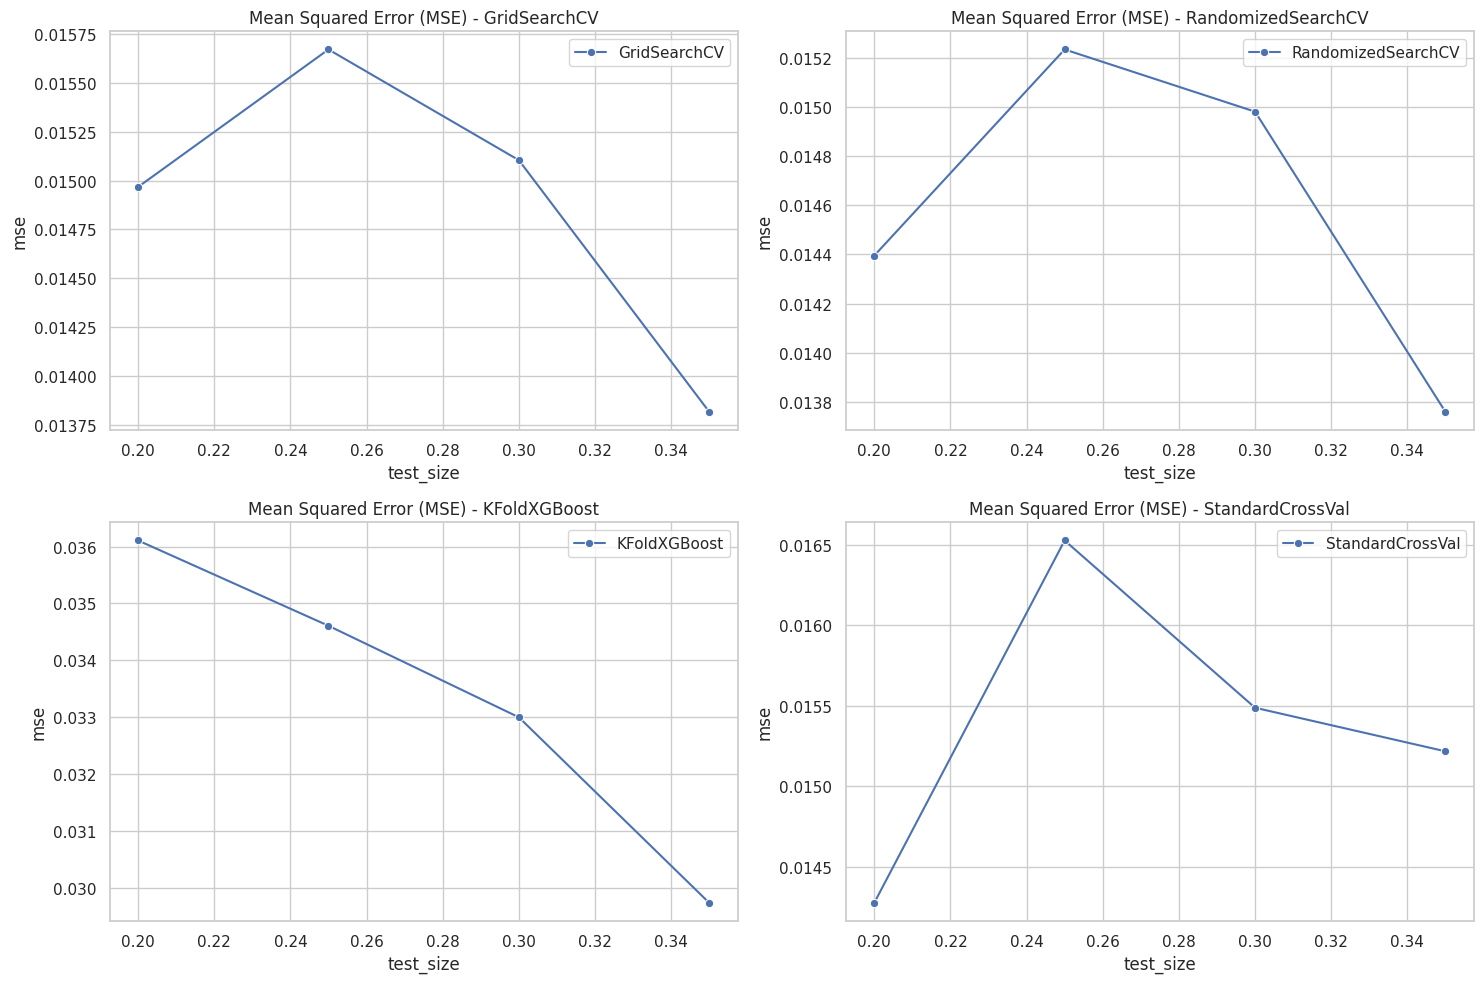

In [66]:
# Filter results for each cross-validation method
grid_search_df = results_df[results_df['method'] == 'GridSearchCV']
random_search_df = results_df[results_df['method'] == 'RandomizedSearchCV']
kfold_df = results_df[results_df['method'] == 'KFoldXGBoost']
standard_cv_df = results_df[results_df['method'] == 'StandardCrossVal']

# Set the style of the visualization
sns.set(style="whitegrid")

# Create a figure and a set of subplots

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot MSE for GridSearchCV
sns.lineplot(x='test_size', y='mse', data=grid_search_df, marker='o', ax=axs[0, 0], label='GridSearchCV')
axs[0, 0].set_title('Mean Squared Error (MSE) - GridSearchCV')

# # Plot MSE for RandomizedSearchCV
sns.lineplot(x='test_size', y='mse', data=random_search_df, marker='o', ax=axs[0, 1], label='RandomizedSearchCV')
axs[0, 1].set_title('Mean Squared Error (MSE) - RandomizedSearchCV')

# # Plot MSE for KFoldXGBoost
sns.lineplot(x='test_size', y='mse', data=kfold_df, marker='o', ax=axs[1, 0], label='KFoldXGBoost')
axs[1, 0].set_title('Mean Squared Error (MSE) - KFoldXGBoost')

# # Plot MSE for StandardCrossVal
sns.lineplot(x='test_size', y='mse', data=standard_cv_df, marker='o', ax=axs[1, 1], label='StandardCrossVal')
axs[1, 1].set_title('Mean Squared Error (MSE) - StandardCrossVal')

# Adjust layout
plt.savefig('01.Dataset-Rofiqul/Visual/AfterRemoveOutliers/004_1_EvaluationResult_HyperparameterTuningCrossval_NoOutlier.png')

plt.tight_layout()

# Show the plots
plt.show()

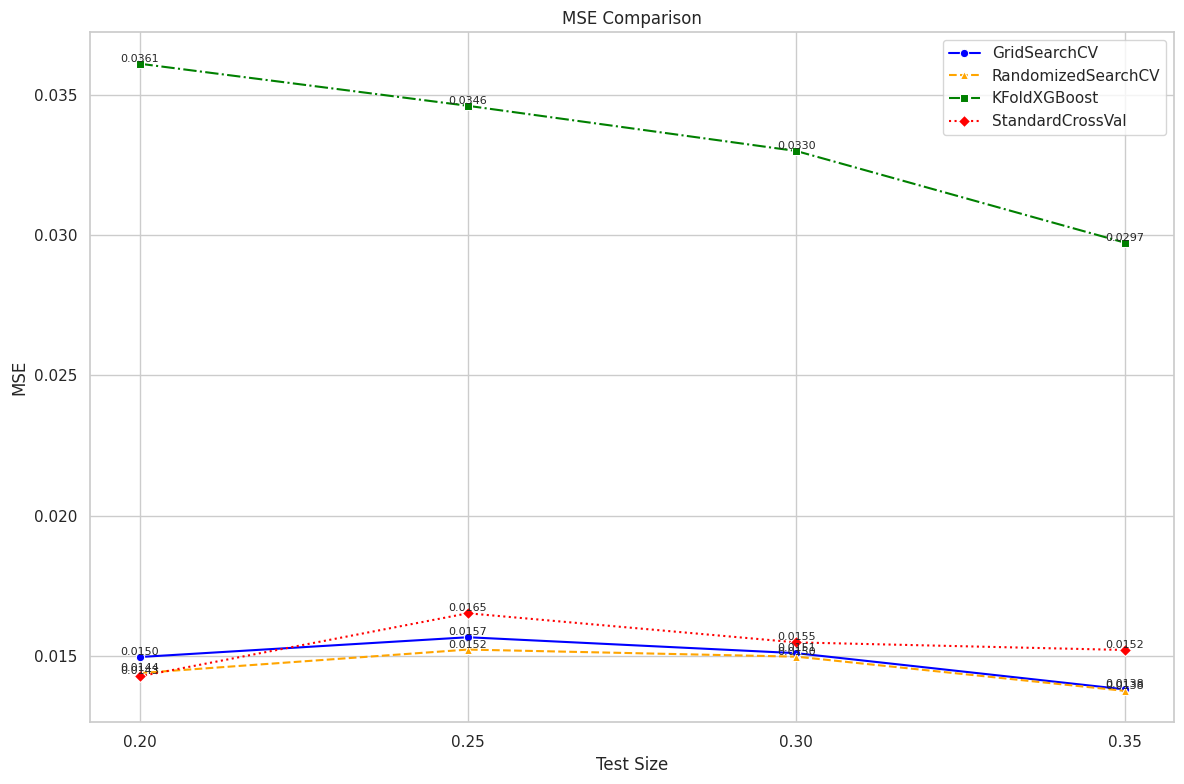

In [67]:
# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(12, 8))

# Filter the x-axis values to only include (0.2, 0.25, 0.3, 0.35)
x_values = [0.2, 0.25, 0.3, 0.35]
grid_search_df = grid_search_df[grid_search_df['test_size'].isin(x_values)]
random_search_df = random_search_df[random_search_df['test_size'].isin(x_values)]
kfold_df = kfold_df[kfold_df['test_size'].isin(x_values)]
standard_cv_df = standard_cv_df[standard_cv_df['test_size'].isin(x_values)]

# Plot MSE for each cross-validation method
sns.lineplot(x='test_size', y='mse', data=grid_search_df, marker='o', label='GridSearchCV', color='blue', linestyle='-')
sns.lineplot(x='test_size', y='mse', data=random_search_df, marker='^', label='RandomizedSearchCV', color='orange', linestyle='--')
sns.lineplot(x='test_size', y='mse', data=kfold_df, marker='s', label='KFoldXGBoost', color='green', linestyle='-.')
sns.lineplot(x='test_size', y='mse', data=standard_cv_df, marker='D', label='StandardCrossVal', color='red', linestyle=':')

# Add labels above the points with 4 digits after the comma
for method, df in zip(['GridSearchCV', 'RandomizedSearchCV', 'KFoldXGBoost', 'StandardCrossVal'],
                     [grid_search_df, random_search_df, kfold_df, standard_cv_df]):
    for i, mse in enumerate(df['mse']):
        ax.text(df['test_size'].iloc[i], mse, f"{mse:.4f}", ha='center', va='bottom', fontsize=8)

# Add labels and title
ax.set_xlabel('Test Size')
ax.set_ylabel('MSE')
ax.set_title('MSE Comparison')
ax.set_xticks(x_values)

plt.legend()
plt.savefig('01.Dataset-Rofiqul/Visual/AfterRemoveOutliers/004_2_MSE_Comparison_HyperparameterTuningCrossval_NoOutlier.png')

plt.tight_layout()
plt.show()

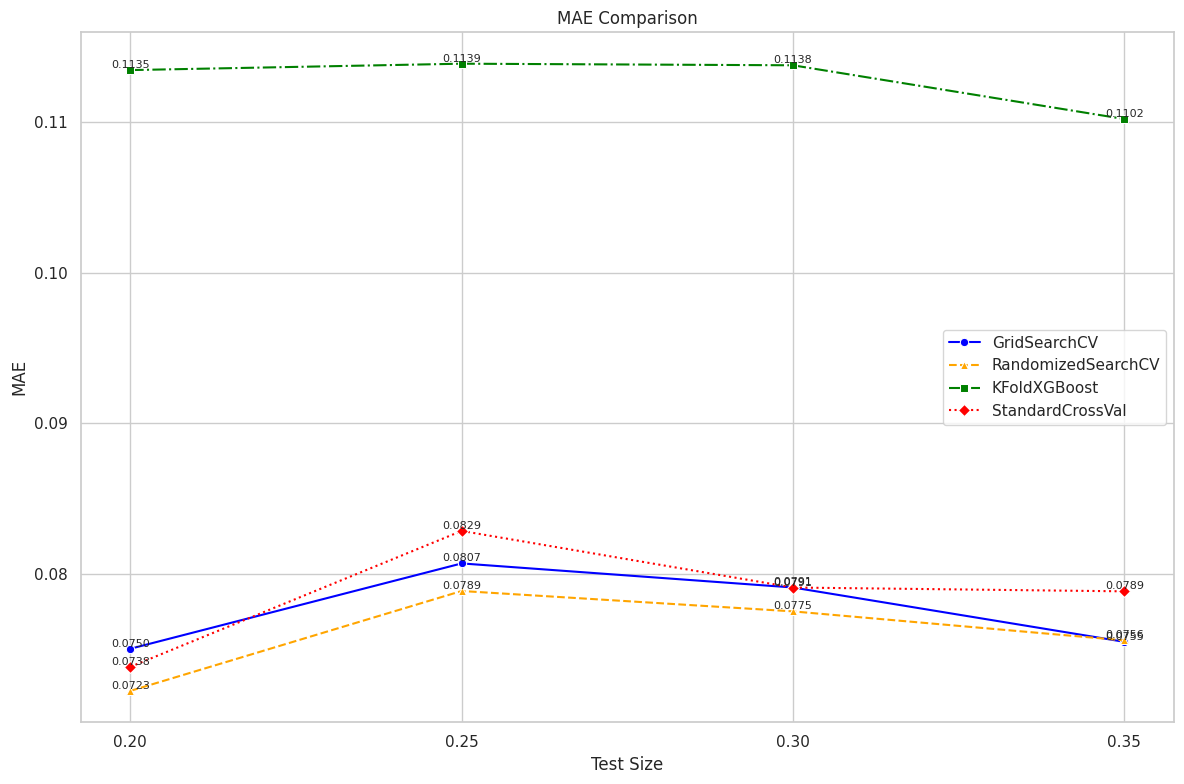

In [68]:
# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(12, 8))

# Filter the x-axis values to only include (0.2, 0.25, 0.3, 0.35)
x_values = [0.2, 0.25, 0.3, 0.35]
grid_search_df = grid_search_df[grid_search_df['test_size'].isin(x_values)]
random_search_df = random_search_df[random_search_df['test_size'].isin(x_values)]
kfold_df = kfold_df[kfold_df['test_size'].isin(x_values)]
standard_cv_df = standard_cv_df[standard_cv_df['test_size'].isin(x_values)]

# Plot MAE for each cross-validation method
sns.lineplot(x='test_size', y='mae', data=grid_search_df, marker='o', label='GridSearchCV', color='blue', linestyle='-')
sns.lineplot(x='test_size', y='mae', data=random_search_df, marker='^', label='RandomizedSearchCV', color='orange', linestyle='--')
sns.lineplot(x='test_size', y='mae', data=kfold_df, marker='s', label='KFoldXGBoost', color='green', linestyle='-.')
sns.lineplot(x='test_size', y='mae', data=standard_cv_df, marker='D', label='StandardCrossVal', color='red', linestyle=':')

# Add labels above the points with 4 digits after the comma
for method, df in zip(['GridSearchCV', 'RandomizedSearchCV', 'KFoldXGBoost', 'StandardCrossVal'],
                     [grid_search_df, random_search_df, kfold_df, standard_cv_df]):
    for i, mae in enumerate(df['mae']):
        ax.text(df['test_size'].iloc[i], mae, f"{mae:.4f}", ha='center', va='bottom', fontsize=8)

# Add labels and title
ax.set_xlabel('Test Size')
ax.set_ylabel('MAE')
ax.set_title('MAE Comparison')
ax.set_xticks(x_values)

plt.legend()
plt.savefig('01.Dataset-Rofiqul/Visual/AfterRemoveOutliers/004_3_MAE_Comparison_HyperparameterTuningCrossval_NoOutlier.png')

plt.tight_layout()
plt.show()

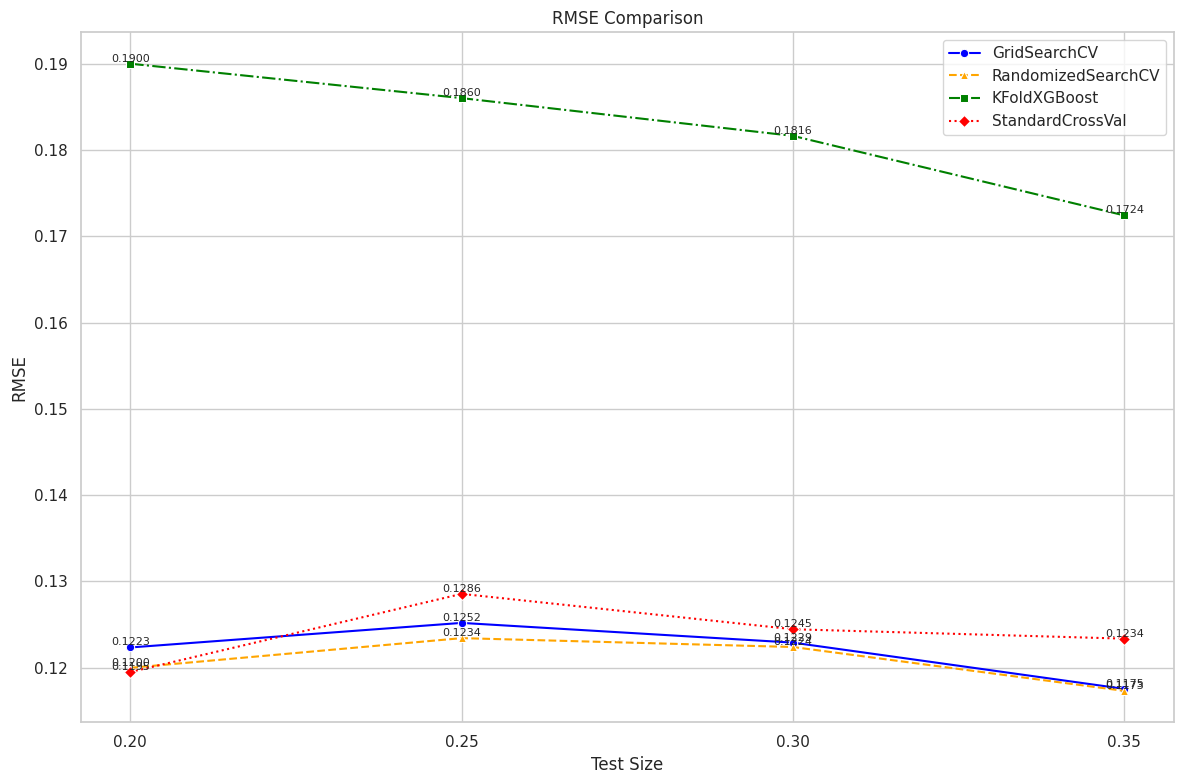

In [69]:
# Set the style of the visualization
sns.set(style="whitegrid")

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(12, 8))

# Filter the x-axis values to only include (0.2, 0.25, 0.3, 0.35)
x_values = [0.2, 0.25, 0.3, 0.35]
grid_search_df = grid_search_df[grid_search_df['test_size'].isin(x_values)]
random_search_df = random_search_df[random_search_df['test_size'].isin(x_values)]
kfold_df = kfold_df[kfold_df['test_size'].isin(x_values)]
standard_cv_df = standard_cv_df[standard_cv_df['test_size'].isin(x_values)]

# Plot RMSE for each cross-validation method
sns.lineplot(x='test_size', y='rmse', data=grid_search_df, marker='o', label='GridSearchCV', color='blue', linestyle='-')
sns.lineplot(x='test_size', y='rmse', data=random_search_df, marker='^', label='RandomizedSearchCV', color='orange', linestyle='--')
sns.lineplot(x='test_size', y='rmse', data=kfold_df, marker='s', label='KFoldXGBoost', color='green', linestyle='-.')
sns.lineplot(x='test_size', y='rmse', data=standard_cv_df, marker='D', label='StandardCrossVal', color='red', linestyle=':')

# Add labels above the points with 4 digits after the comma
for method, df in zip(['GridSearchCV', 'RandomizedSearchCV', 'KFoldXGBoost', 'StandardCrossVal'],
                     [grid_search_df, random_search_df, kfold_df, standard_cv_df]):
    for i, rmse in enumerate(df['rmse']):
        ax.text(df['test_size'].iloc[i], rmse, f"{rmse:.4f}", ha='center', va='bottom', fontsize=8)

# Add labels and title
ax.set_xlabel('Test Size')
ax.set_ylabel('RMSE')
ax.set_title('RMSE Comparison')
ax.set_xticks(x_values)

plt.legend()
plt.savefig('01.Dataset-Rofiqul/Visual/AfterRemoveOutliers/004_4_RMSE_Comparison_HyperparameterTuningCrossval_NoOutlier.png')

plt.tight_layout()
plt.show()

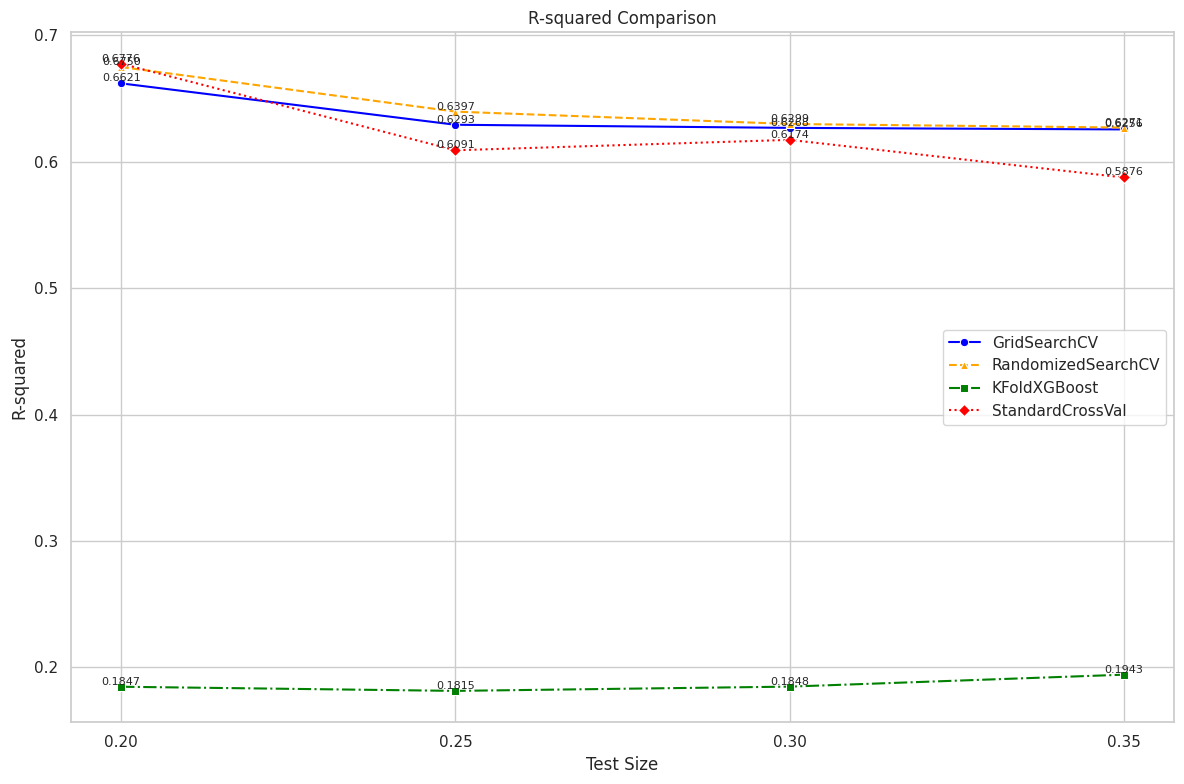

In [70]:
# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(12, 8))

# Filter the x-axis values to only include (0.2, 0.25, 0.3, 0.35)
x_values = [0.2, 0.25, 0.3, 0.35]
grid_search_df = grid_search_df[grid_search_df['test_size'].isin(x_values)]
random_search_df = random_search_df[random_search_df['test_size'].isin(x_values)]
kfold_df = kfold_df[kfold_df['test_size'].isin(x_values)]
standard_cv_df = standard_cv_df[standard_cv_df['test_size'].isin(x_values)]

# Plot R-squared for each cross-validation method
sns.lineplot(x='test_size', y='r2', data=grid_search_df, marker='o', label='GridSearchCV', color='blue', linestyle='-')
sns.lineplot(x='test_size', y='r2', data=random_search_df, marker='^', label='RandomizedSearchCV', color='orange', linestyle='--')
sns.lineplot(x='test_size', y='r2', data=kfold_df, marker='s', label='KFoldXGBoost', color='green', linestyle='-.')
sns.lineplot(x='test_size', y='r2', data=standard_cv_df, marker='D', label='StandardCrossVal', color='red', linestyle=':')

# Add labels above the points with 4 digits after the comma
for method, df in zip(['GridSearchCV', 'RandomizedSearchCV', 'KFoldXGBoost', 'StandardCrossVal'],
                     [grid_search_df, random_search_df, kfold_df, standard_cv_df]):
    for i, r2 in enumerate(df['r2']):
        ax.text(df['test_size'].iloc[i], r2, f"{r2:.4f}", ha='center', va='bottom', fontsize=8)

# Add labels and title
ax.set_xlabel('Test Size')
ax.set_ylabel('R-squared')
ax.set_title('R-squared Comparison')
ax.set_xticks(x_values)

plt.legend()
plt.savefig('01.Dataset-Rofiqul/Visual/AfterRemoveOutliers/004_5_RSquared_Comparison_HyperparameterTuningCrossval_NoOutlier.png')

plt.tight_layout()
plt.show()

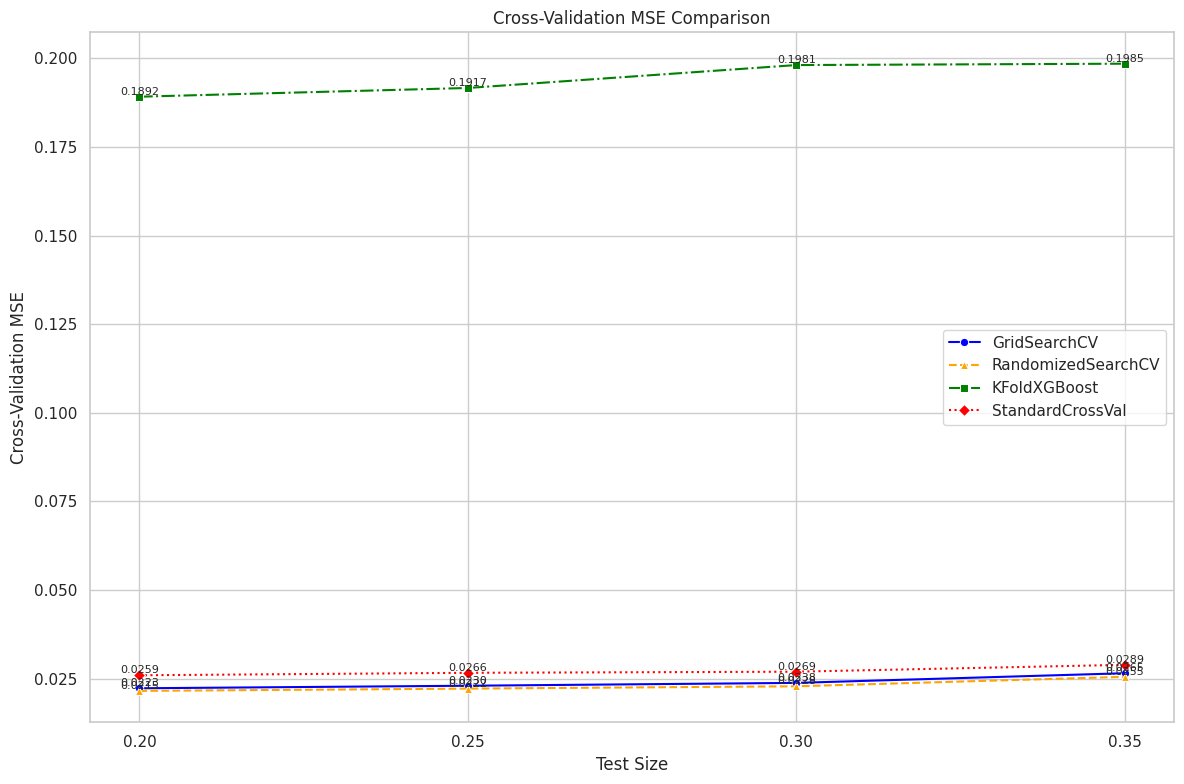

In [71]:
# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(12, 8))

# Filter the x-axis values to only include (0.2, 0.25, 0.3, 0.35)
x_values = [0.2, 0.25, 0.3, 0.35]
grid_search_df = grid_search_df[grid_search_df['test_size'].isin(x_values)]
random_search_df = random_search_df[random_search_df['test_size'].isin(x_values)]
kfold_df = kfold_df[kfold_df['test_size'].isin(x_values)]
standard_cv_df = standard_cv_df[standard_cv_df['test_size'].isin(x_values)]

# Plot cv_score for each cross-validation method
sns.lineplot(x='test_size', y='cv_score', data=grid_search_df, marker='o', label='GridSearchCV', color='blue', linestyle='-')
sns.lineplot(x='test_size', y='cv_score', data=random_search_df, marker='^', label='RandomizedSearchCV', color='orange', linestyle='--')
sns.lineplot(x='test_size', y='cv_score', data=kfold_df, marker='s', label='KFoldXGBoost', color='green', linestyle='-.')
sns.lineplot(x='test_size', y='cv_score', data=standard_cv_df, marker='D', label='StandardCrossVal', color='red', linestyle=':')

# Add labels above the points with 4 digits after the comma
for method, df in zip(['GridSearchCV', 'RandomizedSearchCV', 'KFoldXGBoost', 'StandardCrossVal'],
                     [grid_search_df, random_search_df, kfold_df, standard_cv_df]):
    for i, mse in enumerate(df['cv_score']):
        ax.text(df['test_size'].iloc[i], mse, f"{mse:.4f}", ha='center', va='bottom', fontsize=8)

# Add labels and title
ax.set_xlabel('Test Size')
ax.set_ylabel('Cross-Validation MSE')
ax.set_title('Cross-Validation MSE Comparison')
ax.set_xticks(x_values)

plt.legend()
plt.savefig('01.Dataset-Rofiqul/Visual/AfterRemoveOutliers/004_6_CVScore_Comparison_HyperparameterTuningCrossval_NoOutlier.png')

plt.tight_layout()
plt.show()

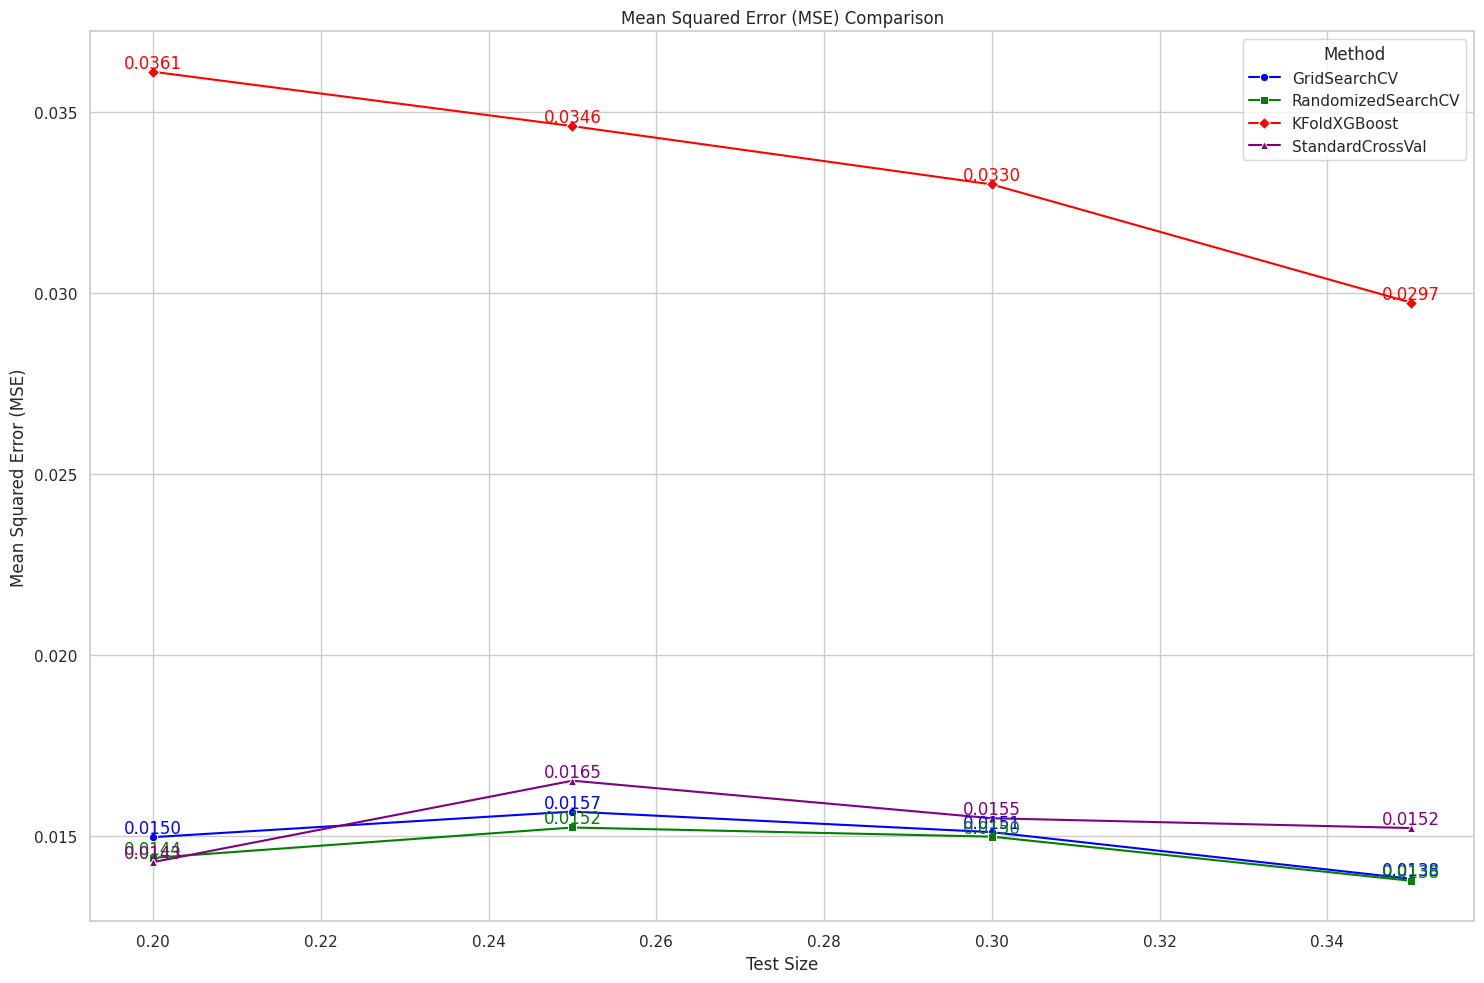

In [63]:
# Set the style of the visualization
sns.set(style="whitegrid")

# Create a figure
plt.figure(figsize=(15, 10))

# Function to add labels
def add_labels(ax, df, x, y, color):
    for i in range(df.shape[0]):
        ax.text(df[x].iloc[i], df[y].iloc[i], f'{df[y].iloc[i]:.4f}', color=color, ha="center", va="bottom")

# Plot MSE for each method in one plot
ax = sns.lineplot(x='test_size', y='mse', data=grid_search_df, marker='o', label='GridSearchCV', color='blue')
add_labels(ax, grid_search_df, 'test_size', 'mse', 'blue')

ax = sns.lineplot(x='test_size', y='mse', data=random_search_df, marker='s', label='RandomizedSearchCV', color='green')
add_labels(ax, random_search_df, 'test_size', 'mse', 'green')

ax = sns.lineplot(x='test_size', y='mse', data=kfold_df, marker='D', label='KFoldXGBoost', color='red')
add_labels(ax, kfold_df, 'test_size', 'mse', 'red')

ax = sns.lineplot(x='test_size', y='mse', data=standard_cv_df, marker='^', label='StandardCrossVal', color='purple')
add_labels(ax, standard_cv_df, 'test_size', 'mse', 'purple')

# Set plot title and labels
plt.title('Mean Squared Error (MSE) Comparison')
plt.xlabel('Test Size')
plt.ylabel('Mean Squared Error (MSE)')

# Show legend
plt.legend(title='Method')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

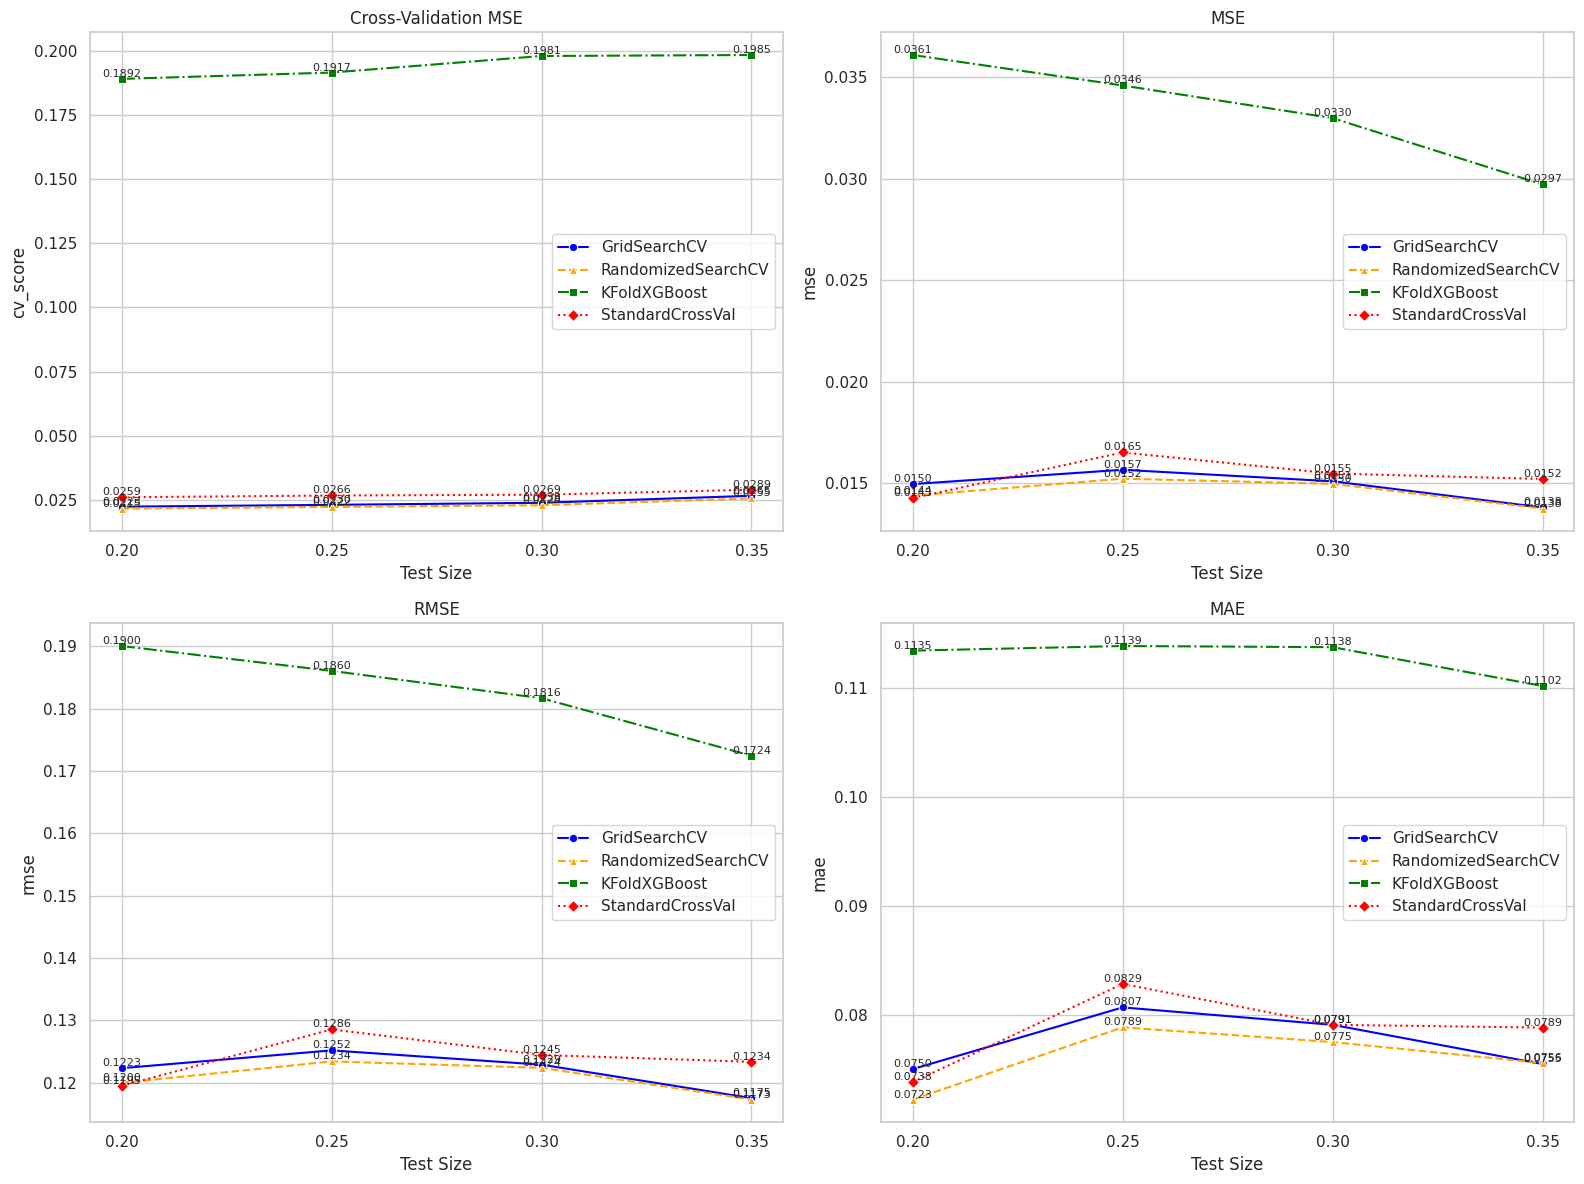

In [72]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Filter the x-axis values to only include (0.2, 0.25, 0.3, 0.35)
x_values = [0.2, 0.25, 0.3, 0.35]
grid_search_df = grid_search_df[grid_search_df['test_size'].isin(x_values)]
random_search_df = random_search_df[random_search_df['test_size'].isin(x_values)]
kfold_df = kfold_df[kfold_df['test_size'].isin(x_values)]
standard_cv_df = standard_cv_df[standard_cv_df['test_size'].isin(x_values)]

# Plot cv_score
axs[0, 0].set_title('Cross-Validation MSE')
sns.lineplot(x='test_size', y='cv_score', data=grid_search_df, marker='o', label='GridSearchCV', color='blue', linestyle='-', ax=axs[0, 0])
sns.lineplot(x='test_size', y='cv_score', data=random_search_df, marker='^', label='RandomizedSearchCV', color='orange', linestyle='--', ax=axs[0, 0])
sns.lineplot(x='test_size', y='cv_score', data=kfold_df, marker='s', label='KFoldXGBoost', color='green', linestyle='-.', ax=axs[0, 0])
sns.lineplot(x='test_size', y='cv_score', data=standard_cv_df, marker='D', label='StandardCrossVal', color='red', linestyle=':', ax=axs[0, 0])

# Add labels above the points with 4 digits after the comma
for method, df in zip(['GridSearchCV', 'RandomizedSearchCV', 'KFoldXGBoost', 'StandardCrossVal'],
                     [grid_search_df, random_search_df, kfold_df, standard_cv_df]):
    for i, mse in enumerate(df['cv_score']):
        axs[0, 0].text(df['test_size'].iloc[i], mse, f"{mse:.4f}", ha='center', va='bottom', fontsize=8)

# Plot MSE
axs[0, 1].set_title('MSE')
sns.lineplot(x='test_size', y='mse', data=grid_search_df, marker='o', label='GridSearchCV', color='blue', linestyle='-', ax=axs[0, 1])
sns.lineplot(x='test_size', y='mse', data=random_search_df, marker='^', label='RandomizedSearchCV', color='orange', linestyle='--', ax=axs[0, 1])
sns.lineplot(x='test_size', y='mse', data=kfold_df, marker='s', label='KFoldXGBoost', color='green', linestyle='-.', ax=axs[0, 1])
sns.lineplot(x='test_size', y='mse', data=standard_cv_df, marker='D', label='StandardCrossVal', color='red', linestyle=':', ax=axs[0, 1])

# Add labels above the points with 4 digits after the comma
for method, df in zip(['GridSearchCV', 'RandomizedSearchCV', 'KFoldXGBoost', 'StandardCrossVal'],
                     [grid_search_df, random_search_df, kfold_df, standard_cv_df]):
    for i, mse in enumerate(df['mse']):
        axs[0, 1].text(df['test_size'].iloc[i], mse, f"{mse:.4f}", ha='center', va='bottom', fontsize=8)

# Plot RMSE
axs[1, 0].set_title('RMSE')
sns.lineplot(x='test_size', y='rmse', data=grid_search_df, marker='o', label='GridSearchCV', color='blue', linestyle='-', ax=axs[1, 0])
sns.lineplot(x='test_size', y='rmse', data=random_search_df, marker='^', label='RandomizedSearchCV', color='orange', linestyle='--', ax=axs[1, 0])
sns.lineplot(x='test_size', y='rmse', data=kfold_df, marker='s', label='KFoldXGBoost', color='green', linestyle='-.', ax=axs[1, 0])
sns.lineplot(x='test_size', y='rmse', data=standard_cv_df, marker='D', label='StandardCrossVal', color='red', linestyle=':', ax=axs[1, 0])

# Add labels above the points with 4 digits after the comma
for method, df in zip(['GridSearchCV', 'RandomizedSearchCV', 'KFoldXGBoost', 'StandardCrossVal'],
                     [grid_search_df, random_search_df, kfold_df, standard_cv_df]):
    for i, rmse in enumerate(df['rmse']):
        axs[1, 0].text(df['test_size'].iloc[i], rmse, f"{rmse:.4f}", ha='center', va='bottom', fontsize=8)

# Plot MAE
axs[1, 1].set_title('MAE')
sns.lineplot(x='test_size', y='mae', data=grid_search_df, marker='o', label='GridSearchCV', color='blue', linestyle='-', ax=axs[1, 1])
sns.lineplot(x='test_size', y='mae', data=random_search_df, marker='^', label='RandomizedSearchCV', color='orange', linestyle='--', ax=axs[1, 1])
sns.lineplot(x='test_size', y='mae', data=kfold_df, marker='s', label='KFoldXGBoost', color='green', linestyle='-.', ax=axs[1, 1])
sns.lineplot(x='test_size', y='mae', data=standard_cv_df, marker='D', label='StandardCrossVal', color='red', linestyle=':', ax=axs[1, 1])

# Add labels above the points with 4 digits after the comma
for method, df in zip(['GridSearchCV', 'RandomizedSearchCV', 'KFoldXGBoost', 'StandardCrossVal'],
                     [grid_search_df, random_search_df, kfold_df, standard_cv_df]):
    for i, mae in enumerate(df['mae']):
        axs[1, 1].text(df['test_size'].iloc[i], mae, f"{mae:.4f}", ha='center', va='bottom', fontsize=8)

# Set x-axis ticks and labels
for ax in axs.flat:
    ax.set_xticks(x_values)
    ax.set_xlabel('Test Size')

# Add legends
axs[0, 0].legend()
axs[0, 1].legend()
axs[1, 0].legend()
axs[1, 1].legend()
plt.savefig('01.Dataset-Rofiqul/Visual/AfterRemoveOutliers/004_7_Evaluation_Comparison_HyperparameterTuningCrossval_NoOutlier.png')


plt.tight_layout()